In [1]:
import pandas as pd
import numpy as np
import itertools as it

import pickle as pcl

# from scipy.spatial.distance import cdist

import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

from collections import Counter

from mpl_toolkits.mplot3d import Axes3D

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [3]:
import hightolowz
import protocluster_completeness_purity 

In [4]:
from scipy.optimize import curve_fit

In [5]:
from itertools import chain, repeat

In [6]:
L = 480.279

In [7]:
zees = ['9p72','8p93','8p22','6p97','5p92','5p03','3p95','3p10','2p07']

In [115]:
directory = '/lustre/scratch/astro/cl478/protoclusters_data/'
out_directory = 'output/'

Load data

In [9]:
gals_mstar = [None] * len(zees)
gals_sfr = [None] * len(zees)

for i, z in enumerate(zees):
    print z
    gals_mstar[i] = pd.read_csv(directory+'henriques2015a_z%s_stellarMass_r200.csv' % z, skiprows=122, skipfooter=1, engine='python')
    gals_sfr[i] = pd.read_csv(directory+'henriques2015a_z%s_sfr_r200.csv' % z, skiprows=122, skipfooter=1, engine='python')

9p72
8p93
8p22
6p97
5p92
5p03
3p95


KeyboardInterrupt: 

In [13]:
gals_sfr5 = [None] * len(zees)

for i, z in enumerate(zees):
    print z
    gals_sfr5[i] = gals_sfr[i][gals_sfr[i]['zn_sfr'] > 5].copy().reset_index(drop=True)
    

9p72
8p93
8p22
6p97
5p92
5p03
3p95
3p10
2p07


In [14]:
cstats = pcl.load(open('data/clustering_stats_r200.p', 'rb'))

cstats_z9p72_sfr = cstats[0]
cstats_z8p93_sfr = cstats[1]
cstats_z8p22_sfr = cstats[2]
cstats_z6p97_sfr = cstats[3]

cstats_z5p92_sfr = cstats[4]
cstats_z5p03_sfr = cstats[5]
cstats_z3p95_sfr = cstats[6]
cstats_z3p10_sfr = cstats[7]
cstats_z2p07_sfr = cstats[8]

cstats_z9p72_mstar9 = cstats[9]
cstats_z8p93_mstar9 = cstats[10]
cstats_z8p22_mstar9 = cstats[11]
cstats_z6p97_mstar9 = cstats[12]

cstats_z5p92_mstar9 = cstats[13]
cstats_z5p03_mstar9 = cstats[14]
cstats_z3p95_mstar9 = cstats[15]
cstats_z3p10_mstar9 = cstats[16]
cstats_z2p07_mstar9 = cstats[17]

cstats_z5p92_mstar10 = cstats[18]
cstats_z5p03_mstar10 = cstats[19]
cstats_z3p95_mstar10 = cstats[20]
cstats_z3p10_mstar10 = cstats[21]
cstats_z2p07_mstar10 = cstats[22]

In [17]:
# import protocluster_completeness_purity
# reload(protocluster_completeness_purity)

# gals_z3p95_sfr = pd.read_csv('data/r200/henriques2015a_z3p95_sfr_r200.csv', skiprows=122, skipfooter=1, engine='python')

# cstats_z3p95_sfr_zdistort = protocluster_completeness_purity.cluster_stats(gals_z3p95_sfr, L, redshift_distort=True, z=3.95)

N Clusters:  2136
Building periodic KDtree...
Calculating cluster properties...


In [19]:
# pcl.dump(cstats_z3p95_sfr_zdistort, open('data/clustering_stats_zdistort.p','w'))
cstats_z3p95_sfr_zdistort = pcl.load(open('data/clustering_stats_zdistort.p','r'))

In [9]:
# eigs = pcl.load(open('data/eigs_r200.p', 'rb'))

# eig_vals_z9p72_mstar9 =eigs[0]
# eig_vals_z8p93_mstar9 =eigs[1]
# eig_vals_z8p22_mstar9 =eigs[2]
# eig_vals_z6p97_mstar9 =eigs[3]
# eig_vals_z5p92_mstar9 =eigs[4]
# eig_vals_z5p03_mstar9 =eigs[5]
# eig_vals_z3p95_mstar9 =eigs[6]
# eig_vals_z3p10_mstar9 =eigs[7]
# eig_vals_z2p07_mstar9 =eigs[8]

# eig_vals_z9p72_sfr = eigs[9]
# eig_vals_z8p93_sfr = eigs[10]
# eig_vals_z8p22_sfr = eigs[11]
# eig_vals_z6p97_sfr = eigs[12]
# eig_vals_z5p92_sfr = eigs[13]
# eig_vals_z5p03_sfr = eigs[14]
# eig_vals_z3p95_sfr = eigs[15]
# eig_vals_z3p10_sfr = eigs[16]
# eig_vals_z2p07_sfr = eigs[17]

# eig_vals_z5p03_mstar10 = eigs[18]
# eig_vals_z3p95_mstar10 = eigs[19]
# eig_vals_z3p10_mstar10 = eigs[20]
# eig_vals_z2p07_mstar10 = eigs[21]

# del eigs

### Radii plot

want to compare to theoretical C & P for ellipse with mean axes values

In [10]:
def theoretical_ratios(overdensity = False, radii = np.arange(1,30,0.1), a=7.62, b=5.17, c=3.66, N = 200000, Rmax=30):
    
    # use mean calculated values
#     a = np.mean(eig_vals_z3p95_sfr[:,0])
#     b = np.mean(eig_vals_z3p95_sfr[:,1])
#     c = np.mean(eig_vals_z3p95_sfr[:,2])

    print "a:", a, "b:", b, "c:", c

    cood_max=np.sqrt(Rmax**2 / 2)

    # uniform distribution
    coordinates = np.reshape(np.random.rand(N*3), (N,3)) * cood_max
    
    in_ellipse = np.array([(coods[0]/a)**2 + (coods[1]/b)**2 + (coods[2]/c)**2 for coods in coordinates])
    
    print coordinates.shape
    
    if overdensity:
        coords_in_ellipse = coordinates[in_ellipse <=1]
        
        for r in range(overdensity):
            coordinates = np.vstack([coordinates, coords_in_ellipse])
            
        in_ellipse = np.array([(coods[0]/a)**2 + (coods[1]/b)**2 + (coods[2]/c)**2 for coods in coordinates])
        
    print coordinates.shape

    R = np.array([np.sum(coods**2)**0.5 for coods in coordinates])

    P = [float(np.sum((R <= r) & (in_ellipse <= 1))) / np.sum(R <= r) for r in radii]
    C = [float(np.sum((R <= r) & (in_ellipse <= 1))) / np.sum(in_ellipse <= 1) for r in radii]

    r_sphere = (a*b*c)**(1./3)

    P_sphere = [float(np.sum((R <= r) & (R <= r_sphere))) / np.sum(R <= r) for r in radii]
    C_sphere = [float(np.sum((R <= r) & (R <= r_sphere))) / np.sum(R <= r_sphere) for r in radii]
    
    return P, C, P_sphere, C_sphere

    

In [11]:
radii = np.arange(1,30,0.1)

P, C, P_sphere, C_sphere = theoretical_ratios()
P_od, C_od, P_sphere_od, C_sphere_od = theoretical_ratios(overdensity=5)

a: 7.62 b: 5.17 c: 3.66
(200000, 3)
(200000, 3)
a: 7.62 b: 5.17 c: 3.66
(200000, 3)
(208450, 3)


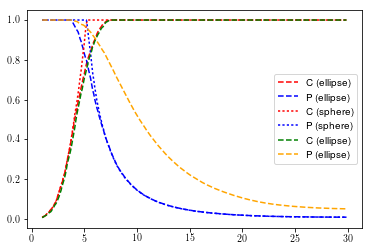

In [12]:
plt.plot(radii, C, label='C (ellipse)', c='red', linestyle='dashed')
plt.plot(radii, P, label='P (ellipse)', c='blue', linestyle='dashed')

plt.plot(radii, C_sphere, label='C (sphere)', c='red', linestyle='dotted')
plt.plot(radii, P_sphere, label='P (sphere)', c='blue', linestyle='dotted')

plt.plot(radii, C_od, label='C (ellipse)', c='green', linestyle='dashed')
plt.plot(radii, P_od, label='P (ellipse)', c='orange', linestyle='dashed')

# plt.plot(radii, C_sphere_od, label='C (sphere)', c='red', linestyle='dotted')
# plt.plot(radii, P_sphere_od, label='P (sphere)', c='blue', linestyle='dotted')

plt.legend()

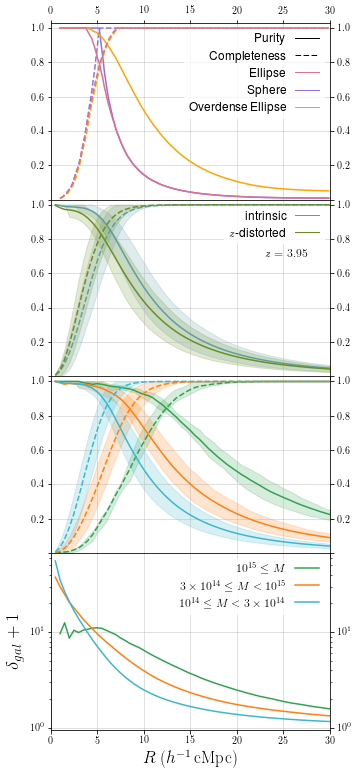

In [65]:
fig = plt.figure(figsize=(5,13))

gs = gridspec.GridSpec(4, 1)

gs.update(hspace=0, wspace=0) #bottom = 0.57, top = 1, 

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[3,0])

rangex = [float(x)/2 for x in range(61)[1:]]

#for i, cstats in enumerate([cstats_2p07_mstar, cstats_3p10_mstar, cstats_3p95_mstar]):
i = 0
cstats = cstats_z3p95_sfr


## Plot 1
completeness = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[0] for x in np.array(cstats['cstats'])]).T])
purity = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[1] for x in np.array(cstats['cstats'])]).T])

# theoretical curves
ax1.plot(radii, C_sphere, label='C (sphere)', c='mediumpurple', linestyle='dashed')
ax1.plot(radii, P_sphere, label='P (sphere)', c='mediumpurple', linestyle='solid')

ax1.plot(radii, C_od, label='C (sphere)', c='orange', linestyle='dashed')
ax1.plot(radii, P_od, label='P (sphere)', c='orange', linestyle='solid')

ax1.plot(radii, C, label='C (ellipse)', c='palevioletred', linestyle='dashed')
ax1.plot(radii, P, label='P (ellipse)', c='palevioletred', linestyle='solid')

# plot 2
c ='cadetblue'
ax2.fill_between(rangex, completeness[:,0], completeness[:,1], alpha=0.2, color=c)
ax2.fill_between(rangex, purity[:,0], purity[:,1], alpha=0.2, color=c)

ax2.plot(rangex, np.mean([x[0] for x in np.array(cstats['cstats'])], axis=0), c=c, linestyle='dashed')
ax2.plot(rangex, np.mean([x[1] for x in np.array(cstats['cstats'])], axis=0), c=c)

# z distort

completeness = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[0] for x in np.array(cstats_z3p95_sfr_zdistort['cstats'])]).T])
purity = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[1] for x in np.array(cstats_z3p95_sfr_zdistort['cstats'])]).T])

c ='olivedrab'
ax2.fill_between(rangex, completeness[:,0], completeness[:,1], alpha=0.2, color=c)
ax2.fill_between(rangex, purity[:,0], purity[:,1], alpha=0.2, color=c)

ax2.plot(rangex, np.mean([x[0] for x in np.array(cstats_z3p95_sfr_zdistort['cstats'])], axis=0), c=c, linestyle='dashed')

ax2.plot(rangex, np.mean([x[1] for x in np.array(cstats_z3p95_sfr_zdistort['cstats'])], axis=0), c=c)


# intercepts = [np.mean([x[0] for x in np.array(cstats['cstats'])], axis=0)[np.where([x == r for x in rangex])][0] for r in [4,7,10]]
# ax2.vlines([4,7,10],0,intercepts, color=c, linewidth=1, linestyle='dashed')
# ax2.hlines(intercepts, [4,7,10],30, color=c, linewidth=1, linestyle='dashed')

# intercepts = [np.mean([x[1] for x in np.array(cstats['cstats'])], axis=0)[np.where([x == r for x in rangex])][0] for r in [4,7,10]]
# ax2.vlines([4,7,10],0,intercepts, color=c, linewidth=1, linestyle='solid')
# ax2.hlines(intercepts, [4,7,10], 0, color=c, linewidth=1, linestyle='solid')


# Plot 3 + 4
mask_A = np.array(cstats['clusters']['z0_central_mcrit200']) > 1e5
mask_B = (np.array(cstats['clusters']['z0_central_mcrit200']) > 3e4) & (np.array(cstats['clusters']['z0_central_mcrit200']) <= 1e5)
mask_C = (np.array(cstats['clusters']['z0_central_mcrit200']) > 1e4) & (np.array(cstats['clusters']['z0_central_mcrit200']) <= 3e4)
    
for i, mask in enumerate([mask_A, mask_B, mask_C]):
    
    ax4.semilogy(rangex, np.nanmean([x[2] for x in np.array(cstats['cstats'])[mask]],axis=0) + 1,
                 c=cmap[i*2], ls='solid')
    
#     dgal_range = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[2] for x in np.array(cstats['cstats'])[mask]]).T])
#     ax1.fill_between(rangex, dgal_range[:,0], dgal_range[:,1], alpha=0.2, color=cmap[i*2])
    
    completeness = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[0] for x in np.array(cstats['cstats'])[mask]]).T])
    purity = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[1] for x in np.array(cstats['cstats'])[mask]]).T])

    ax3.fill_between(rangex, completeness[:,0], completeness[:,1], alpha=0.2, color=cmap[i*2])

    ax3.fill_between(rangex, purity[:,0], purity[:,1], alpha=0.2, color=cmap[i*2])

    ax3.plot(rangex, np.mean([x[0] for x in np.array(cstats['cstats'])[mask]], axis=0), 
             c=cmap[i*2], linestyle='dashed')
    
    ax3.plot(rangex, np.mean([x[1] for x in np.array(cstats['cstats'])[mask]], axis=0), c=cmap[i*2])


ax4.set_xlabel('$R \;(h^{-1} \,\mathrm{cMpc})$', size=17)
ax4.set_ylabel('$\delta_{gal} + 1$', size=19)

ax1.xaxis.tick_top()

for ax in [ax1,ax2,ax3]:
    ax.set_yticklabels(['','$0.2$','$0.4$','$0.6$','$0.8$','$1.0$'])

ax2.set_xticklabels([])
ax3.set_xticklabels([])

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(0, 1.03)
    

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(0, 30)
    ax.grid(alpha=0.5)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelright=True)

line_z = []
for i in range(3):
    line_z.append(plt.Line2D((0,1),(0,0), color=cmap[i*2], linestyle='solid'))
    
legend4 = ax4.legend(handles=[line for line in line_z], 
                   labels=['$10^{15} \leq M$',
                           '$3 \\times 10^{14} \leq M < 10^{15}$',
                           '$10^{14} \leq M < 3 \\times 10^{14}$'],
                   prop={'size':12}, loc=1)

line_comp = plt.Line2D((0,1.5),(0,0), color='black', linestyle='solid', linewidth=1)
line_puri = plt.Line2D((0,1.5),(0,0), color='black', linestyle='dashed', linewidth=1)
line_theory_ell = plt.Line2D((0,1.5),(0,0), color='palevioletred', linestyle='solid', linewidth=1)
line_theory_sph = plt.Line2D((0,1.5),(0,0), color='mediumpurple', linestyle='solid', linewidth=1)
line_theory_ell_od = plt.Line2D((0,1.5),(0,0), color='orange', linestyle='solid', linewidth=1)

legend1 = ax1.legend(handles=[line_comp, line_puri, line_theory_ell, line_theory_sph, line_theory_ell_od], 
                   labels=['Purity', 'Completeness','Ellipse','Sphere', 'Overdense Ellipse'],
                   prop={'size':12}, loc=1)


line_actual = plt.Line2D((0,1.5),(0,0), color='cadetblue', linestyle='solid', linewidth=1)
line_zdistort = plt.Line2D((0,1.5),(0,0), color='olivedrab', linestyle='solid', linewidth=1)

legend2 = ax2.legend(handles=[line_actual, line_zdistort],labels=['intrinsic', '$z$-distorted'],prop={'size':12}, loc=1)
ax2.text(23, 0.7, '$z = 3.95$', size=12)

for legend in [legend1,legend2,legend4]:
    
    legend.get_frame().set_edgecolor('white')

    # right align
    vp = legend._legend_box._children[-1]._children[0] 
    for c in vp._children: 
        c._children.reverse() 
    vp.align="right" 


# plt.savefig("../papers/protoclusters/images/compur_masscomp_dgal.png", bbox_inches='tight', dpi=300)

NameError: name 'cstats_z8p22_sfr' is not defined

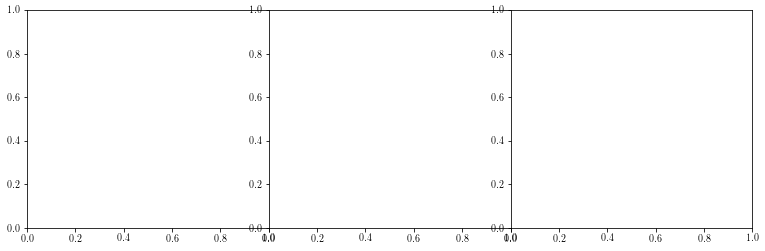

In [8]:
fig = plt.figure(figsize=(13,4))

gs = gridspec.GridSpec(1, 3)

gs.update(hspace=0, wspace=0) #bottom = 0.57, top = 1, 

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])


all_cstats = [cstats_z8p22_sfr, cstats_z6p97_sfr, cstats_z5p92_sfr, cstats_z5p03_sfr, 
              cstats_z3p95_sfr, cstats_z3p10_sfr, cstats_z2p07_sfr]
zeds = ['$8.22$','$6.97$','$5.92$','$5.03$','$3.95$','$3.10$','$2.07$']

for i, (cstats, z) in enumerate(zip(all_cstats, zeds)):
    
    mask_A = np.array(cstats['clusters']['z0_central_mcrit200']) > 1e5
    mask_B = (np.array(cstats['clusters']['z0_central_mcrit200']) > 3e4) & (np.array(cstats['clusters']['z0_central_mcrit200']) <= 1e5)
    mask_C = (np.array(cstats['clusters']['z0_central_mcrit200']) > 1e4) & (np.array(cstats['clusters']['z0_central_mcrit200']) <= 3e4)    

    for ax, mask in zip([ax1,ax2,ax3], [mask_A, mask_B, mask_C]):

        ax.semilogy(rangex, np.nanmean([x[2] for x in np.array(cstats['cstats'])[mask]],axis=0) + 1,
                     c=cmap[::-1][i+5], label=z)

    
for ax in [ax1,ax2,ax3]:
    ax.set_ylim(1, 400)
    ax.set_xlabel('$R \;(h^{-1} \,\mathrm{cMpc})$', size=14)

ax2.set_yticklabels([])
ax3.yaxis.set_ticks_position('right')

ax1.text(20, 200, '$10^{15} \leq M$', size=17, color='black', alpha=0.7)
ax2.text(10, 200, '$3 \\times 10^{14} \leq M < 10^{15}$', size=17, color='black', alpha=0.7)
ax3.text(10, 200, '$10^{14} \leq M < 3 \\times 10^{14}$', size=17, color='black', alpha=0.7)                        
                           
ax1.set_ylabel('$\delta_{gal} + 1$', size=19)


ax3.text(0.61, 0.725, '$z =$', size=13, transform=ax3.transAxes)
legend = ax3.legend(bbox_to_anchor=(0.95, 0.8), bbox_transform=ax3.transAxes)

legend.get_frame().set_edgecolor('white')

# right align
vp = legend._legend_box._children[-1]._children[0] 
for c in vp._children: 
    c._children.reverse() 
vp.align="right" 


# plt.savefig("../papers/protoclusters/images/dgal_profiles.png", bbox_inches='tight', dpi=300)

### $R \;/\; \delta_{z}$  stats

In [156]:
import pc_cp_cylinder
reload(pc_cp_cylinder)

# cylinder_mstar = [None] * len(zees)
# cylinder_sfr = [None] * len(zees)
# cylinder_sfr5 = [None] * len(zees)

# for i, z in enumerate(zees):
#     print z
#     cylinder_sfr5[i] = pc_cp_cylinder.cluster_stats(gals_sfr5[i], L=L)
#     cylinder_mstar[i] = pc_cp_cylinder.cluster_stats(gals_mstar[i], L=L)
#     cylinder_sfr[i] = pc_cp_cylinder.cluster_stats(gals_sfr[i], L=L)
    
# pcl.dump(cylinder_sfr, open('data/cylinder_sfr.pcl','wb'))
# pcl.dump(cylinder_mstar, open('data/cylinder_mstar.pcl','wb'))
# pcl.dump(cylinder_sfr5, open('data/cylinder_sfr5.pcl','wb'))

cylinder_mstar = pcl.load(open('data/cylinder_mstar.pcl','rb'))
cylinder_sfr = pcl.load(open('data/cylinder_sfr.pcl','rb'))
cylinder_sfr5 = pcl.load(open('data/cylinder_sfr5.pcl','rb'))

In [157]:
r = [2.5,7]            # [2.5, 5., 7.5, 10., 15.]
deltaz = [2.5,7]       # [2.5, 5., 7.5, 10., 15.]

save all properties in a single array to allow fit

In [158]:
feature_array = [None] * len(zees)
predictor_array = [None] * len(zees)

cylinder = cylinder_mstar

for i, z in enumerate(zees):
    
    cstats = cylinder[i]['cstats']#[np.array(cylinder[i]['clusters']['z0_central_mcrit200'] > 1e4)]
    cmass = cylinder[i]['clusters']#[np.array(cylinder[i]['clusters']['z0_central_mcrit200'] > 1e4)]

    # create array with n_clusters * deltaz * R entries
#     x = np.zeros((np.product(cstats.shape[:3]), 3))

    x = np.zeros((cstats.shape[0], 3))
    
    x[:,0] = cstats[:,0].flatten() # dgal (R= 2.5)
    x[:,1] = cstats[:,1].flatten() # dgal (R= 7)
    
#     x[:,1] = np.array(list(chain.from_iterable(repeat(e, cstats.shape[2]) for e in deltaz)) *\
#                   cstats.shape[0])
#     x[:,2] = r * np.product(cstats.shape[:2])
    
    x[:,2] = float(z.replace('p','.'))
    
#     y = np.array(list(chain.from_iterable(repeat(e, np.product(cstats.shape[1:3])) for e in \
#                         np.log10(np.array(cmass['z0_central_mcrit200']) * 1e10))))

    y = np.array(cmass['z0_central_mcrit200']) / 1e3#* 1e10
    
    feature_array[i] = x
    predictor_array[i] = y
    
    
feature_array = np.vstack(feature_array)
predictor_array = np.hstack(predictor_array)

In [159]:
def r2(ydata, ypred):
    residuals = ydata - ypred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)

    return 1 - (ss_res / ss_tot)

#### Fit z and single feature

In [160]:
#mask = np.array([x not in [9.72,8.93,8.22,6.97,5.92] for x in feature_array[:,3]])\
# z_mask = np.array([x not in [9.72,8.93,8.22] for x in feature_array[:,3]])
# shape_mask = (feature_array[:,2] == 7) & (feature_array[:,1] == 7)
#shape_mask = (feature_array[:,2] == feature_array[:,1])
# mask = z_mask & shape_mask

mask = np.array([x not in [9.72,8.93,8.22] for x in feature_array[:,2]])

fit_mask = mask & (feature_array[:,1] > 7) #& (predictor_array > 3.162)

lin_fit_mask = mask & (feature_array[:,1] > 7) #& (predictor_array > 3.162)

zeds = ['2p07','3p10','3p95','5p03','5p92','6p97']

In [161]:
# Need to fit inverse otherwise fit is poor
def func_inv(x, a, b, c, d, C):
    return ((x[0] - C) / (a*(x[1]+1)**b))**(1./c) - 1

def func(x, a, b, c, d, C):
    return a * (x[1]+1)**b * (x[0]+1)**c + C 

def linear_func_inv(x, a, b, c, d, C):
    return ((x[0] - C) / (a*(x[1]+1)**b)) - 1

def linear_func(x, a, b, c, d, C):
    return a * (x[1]+1)**b * (x[0]+1) + C

inverse fit

In [162]:
# lin_popt, lin_pcov = curve_fit(linear_func_inv, np.vstack([predictor_array[lin_fit_mask], feature_array[lin_fit_mask,2]]), 
#                        feature_array[lin_fit_mask, 1], maxfev=20000)

In [163]:
# popt, pcov = curve_fit(func_inv, np.vstack([predictor_array[fit_mask], feature_array[fit_mask,2]]), 
#                        feature_array[fit_mask, 1], maxfev=20000)#, sigma=1./feature_array[fit_mask, 1])

regular fit

In [164]:
lin_popt, lin_pcov = curve_fit(linear_func, feature_array[:,[1,2]][lin_fit_mask].T,
                       predictor_array[lin_fit_mask], maxfev=20000)#, p0=p0)

In [165]:
popt, pcov = curve_fit(func, feature_array[:,[1,2]][fit_mask].T, 
                       predictor_array[fit_mask], maxfev=20000)#, sigma=feature_array[fit_mask, 1])#, p0=p0)

In [166]:
print lin_popt
print popt

[ 18.67438018  -1.3317707    1.           1.          -8.56667748]
[ 12.33818911  -1.85933502   1.35554556   1.          -1.0961065 ]


In [167]:
print "$R^{2} (linear)$:",r2(predictor_array[lin_fit_mask], 
                             linear_func(feature_array[:,np.array([1,2])][lin_fit_mask].T, 
            lin_popt[0], lin_popt[1], lin_popt[2], lin_popt[3], lin_popt[4]))

print "$R^{2} (polynomial)$:",r2(predictor_array[fit_mask], func(feature_array[:,np.array([1,2])][fit_mask].T, 
            popt[0], popt[1], popt[2], popt[3], popt[4]))

print "$R^{2} (linear)$:",r2(feature_array[lin_fit_mask,1], linear_func_inv(np.vstack([predictor_array[lin_fit_mask],
            feature_array[lin_fit_mask,2]]), lin_popt[0], lin_popt[1], lin_popt[2], lin_popt[3], lin_popt[4]))

print "$R^{2} (polynomial)$:",r2(feature_array[fit_mask,1], func_inv(np.vstack([predictor_array[fit_mask],
            feature_array[fit_mask,2]]), popt[0], popt[1], popt[2], popt[3], popt[4]))

$R^{2} (linear)$: 0.438202470997
$R^{2} (polynomial)$: 0.443296311121
$R^{2} (linear)$: -0.0943380514004
$R^{2} (polynomial)$: -0.110774697695


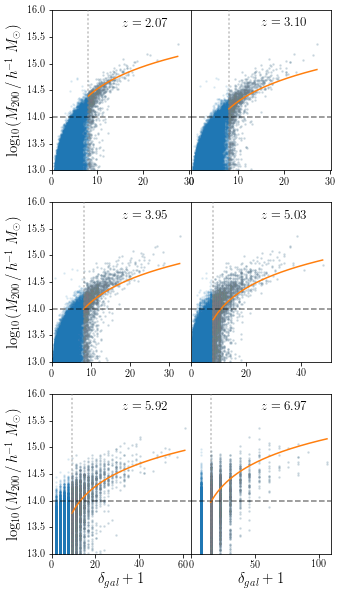

In [155]:
fig = plt.figure(figsize=(5,10))

gs1 = gridspec.GridSpec(3, 2)

gs1.update(wspace=0, hspace=0.2)

ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[0,1])
ax3 = fig.add_subplot(gs1[1,0])
ax4 = fig.add_subplot(gs1[1,1])
ax5 = fig.add_subplot(gs1[2,0])
ax6 = fig.add_subplot(gs1[2,1])

axes = [ax1,ax2,ax3,ax4,ax5,ax6]

def scale(x):
    return np.log10(x * 1e3 * 1e10)

for ax, z in zip(axes, zeds):
    
    ax.text(0.5, 0.9, '$z = '+z.replace('p','.')+'$', transform=ax.transAxes, size=13)
    
    z_mask = (feature_array[:,2] == float(z.replace('p','.'))) & fit_mask
    z_mask_lin = (feature_array[:,2] == float(z.replace('p','.'))) & lin_fit_mask
    z_mask_all = (feature_array[:,2] == float(z.replace('p','.')))
    
    ax.plot(feature_array[z_mask_all,1]+1, scale(predictor_array[z_mask_all]), '.', markersize=3, alpha=0.1)
    ax.plot(feature_array[z_mask,1]+1, scale(predictor_array[z_mask]), '.', markersize=3, alpha=0.1, c='grey')
    
    dgal_range = np.linspace(feature_array[z_mask,1].min(), feature_array[z_mask,1].max(), np.sum(z_mask))
    ax.plot(dgal_range + 1, scale(func(np.vstack([dgal_range, feature_array[z_mask,2]]),
                             popt[0], popt[1], popt[2], popt[3], popt[4])))
    
#     dgal_range = np.linspace(feature_array[z_mask_lin,1].min(), feature_array[z_mask_lin,1].max(), np.sum(z_mask_lin))
#     ax.plot(dgal_range + 1, scale(linear_func(np.vstack([dgal_range, feature_array[z_mask_lin,2]]),
#              lin_popt[0], lin_popt[1], lin_popt[2], lin_popt[3], lin_popt[4])))
    
#     ax.hlines(13.5, 0, feature_array[z_mask,1].max() + 4, alpha=0.5, linestyle='dotted', color='grey',zorder=10)    
    ax.hlines(14, 0, feature_array[z_mask,1].max() + 4, alpha=0.5, linestyle='dashed', color='black',zorder=10)
    
    ax.vlines(feature_array[z_mask,1].min() + 1, 13, 16, alpha=0.5, linestyle='dotted', color='grey',zorder=10)

    ax.set_xlim(0,feature_array[z_mask,1].max() + 4)
    ax.set_ylim(13, 16)
    
for ax in [ax2, ax4, ax6]:
    ax.set_yticklabels([])
    ax.set_yticks([])
    
for ax in [ax1, ax3, ax5]:
    ax.set_ylabel('$\mathrm{log_{10}} (M_{200}\,/ \,h^{-1}\;M_{\odot})$', size=15)
    
for ax in [ax5,ax6]:
    ax.set_xlabel('$\delta_{gal} + 1$', size=15)

    
# plt.savefig(out_directory+'mass_fit.png', bbox_inches='tight', dpi=300)

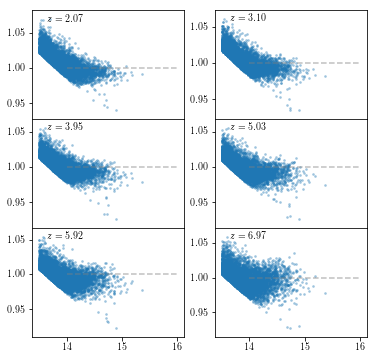

In [897]:
fig = plt.figure(figsize=(6,6))

gs1 = gridspec.GridSpec(3, 2)

gs1.update(hspace=0) #bottom = 0.57, top = 1, wspace=0)

ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[0,1])
ax3 = fig.add_subplot(gs1[1,0])
ax4 = fig.add_subplot(gs1[1,1])
ax5 = fig.add_subplot(gs1[2,0])
ax6 = fig.add_subplot(gs1[2,1])

axes = [ax1,ax2,ax3,ax4,ax5,ax6]

for ax, z in zip(axes, zeds):
    
    ax.text(0.1, 0.9, '$z = '+z.replace('p','.')+'$', transform=ax.transAxes)
    
    z_mask = (feature_array[:,2] == float(z.replace('p','.'))) & fit_mask
    
#     ax.scatter(predictor_array[z_mask], 
#                linear_func(feature_array[:,np.array([1,2])][z_mask].T, 
#                            lin_popt[0], lin_popt[1], lin_popt[2], lin_popt[3], lin_popt[4])
#                / predictor_array[z_mask], s=3, alpha=0.3, c='green')
    
    ax.scatter(scale(predictor_array[z_mask]), 
               scale(func(feature_array[:,np.array([1,2])][z_mask].T, popt[0], popt[1], popt[2], popt[3], popt[4]))
               / scale(predictor_array[z_mask]), s=3, alpha=0.3)

    ax.hlines(1,14,16, linestyle='dashed', color='grey',alpha=0.5)

#### Multiple scales

In [898]:
mask = np.array([x not in [9.72,8.93,8.22] for x in feature_array[:,2]]) \
& (feature_array[:,1] > 3) & (predictor_array > 3.162)

p0 = [1.35, 1.75, 0.5, 0.5, 13]

# two overdensities
def func_inv(x, a, b, c, d, C):
#     return ((x[2]-C) / (a * ((x[0]+1)**b)* (x[1]+2)**d))**(1./c) - 1
    return ((x[2] - C)  / (a * (x[0]+1)**b * (x[1]+1)**d))**(1./c) - 1

def func(x, a, b, c, d, C):
#     return a * (x[0]+1)**b * (x[2]+1)**c * (x[1]+2)**d + C 
    return a * (x[0]+1)**b * (x[2]+1)**c * (x[1]+1)**d + C

# popt, pcov = curve_fit(func_inv, np.vstack((feature_array[:,np.array([2,0])][mask].T, predictor_array[mask].T)), 
#                        feature_array[mask, 1], maxfev=20000)#, p0=p0) #, sigma = predictor_array[mask])#

popt, pcov = curve_fit(func, feature_array[:,np.array([2,0,1])][mask].T, 
                       predictor_array[mask], maxfev=20000)#, p0=p0) #, sigma = predictor_array[mask])#

print popt

/home/chris/anaconda/envs/cosmo/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in power


[  8.53316839e-01  -4.69041828e-01   1.85410576e+00   6.68257950e-08
  -1.05564323e+00]


In [899]:
print "$R^{2}$:",r2(predictor_array[mask], func(feature_array[:,np.array([2,0,1])][mask].T, 
            popt[0], popt[1], popt[2], popt[3], popt[4]))

$R^{2}$: 0.648006571931


/home/chris/anaconda/envs/cosmo/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in log10


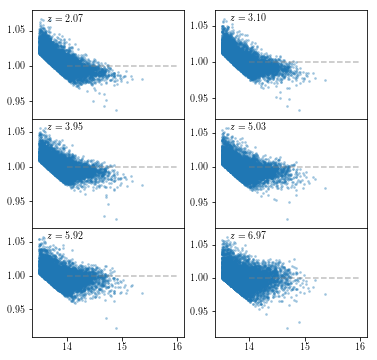

In [900]:
fig = plt.figure(figsize=(6,6))

gs1 = gridspec.GridSpec(3, 2)

gs1.update(hspace=0) #bottom = 0.57, top = 1, wspace=0)

ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[0,1])
ax3 = fig.add_subplot(gs1[1,0])
ax4 = fig.add_subplot(gs1[1,1])
ax5 = fig.add_subplot(gs1[2,0])
ax6 = fig.add_subplot(gs1[2,1])

axes = [ax1,ax2,ax3,ax4,ax5,ax6]

for ax, z in zip(axes, zeds):
    
    ax.text(0.1, 0.9, '$z = '+z.replace('p','.')+'$', transform=ax.transAxes)
    
    z_mask = (feature_array[:,2] == float(z.replace('p','.'))) & mask
    
    ax.scatter(scale(predictor_array[z_mask]),
            scale(func(feature_array[:,np.array([2,0,1])][z_mask].T, popt[0], popt[1], popt[2], popt[3], popt[4]))
             / scale(predictor_array[z_mask]), s=3, alpha=0.3)

    ax.hlines(1,14,16, linestyle='dashed', color='grey',alpha=0.5)

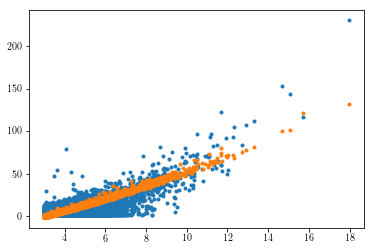

In [813]:
z_mask = (feature_array[:,2] == 2.07) & mask

plt.plot(feature_array[z_mask,1],
         predictor_array[z_mask], '.')

plt.plot(feature_array[z_mask,1],
        func(feature_array[:,np.array([2,0,1])][z_mask].T,
             popt[0], popt[1], popt[2], popt[3], popt[4]), '.')

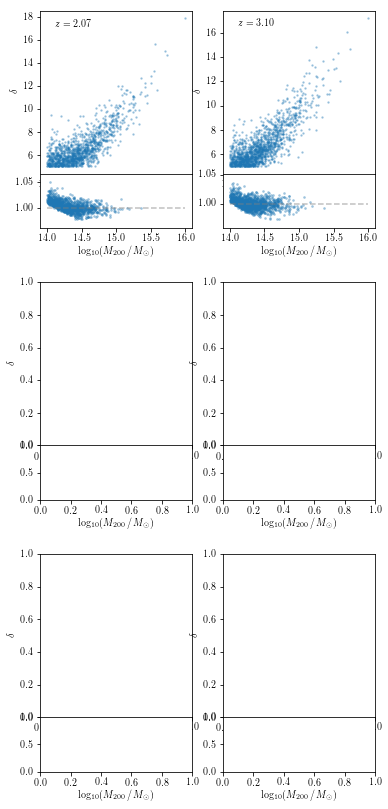

In [809]:
fig = plt.figure(figsize=(6,14))

gs1 = gridspec.GridSpec(14, 2)

gs1.update(hspace=0) #bottom = 0.57, top = 1, wspace=0)

ax1 = fig.add_subplot(gs1[0:3,0])
ax2 = fig.add_subplot(gs1[0:3,1])
ax3 = fig.add_subplot(gs1[5:8,0])
ax4 = fig.add_subplot(gs1[5:8,1])
ax5 = fig.add_subplot(gs1[10:13,0])
ax6 = fig.add_subplot(gs1[10:13,1])

ax1b = fig.add_subplot(gs1[3,0])
ax2b = fig.add_subplot(gs1[3,1])
ax3b = fig.add_subplot(gs1[8,0])
ax4b = fig.add_subplot(gs1[8,1])
ax5b = fig.add_subplot(gs1[13,0])
ax6b = fig.add_subplot(gs1[13,1])


axes = [ax1,ax2,ax3,ax4,ax5,ax6]
axesb = [ax1b,ax2b,ax3b,ax4b,ax5b,ax6b]

for ax, axb, z in zip(axes, axesb, zeds):
    
    ax.text(0.1, 0.9, '$z = '+z.replace('p','.')+'$', transform=ax.transAxes)
    
    z_mask = (feature_array[:,2] == float(z.replace('p','.'))) & mask
    
    axb.scatter(predictor_array[z_mask],
            func(feature_array[:,np.array([2,0,1])][z_mask].T, popt[0], popt[1], popt[2], popt[3], popt[4])
             / predictor_array[z_mask], s=3, alpha=0.3)

    axb.hlines(1,14,16, linestyle='dashed', color='grey',alpha=0.5)
    
    ax.plot(predictor_array[z_mask], feature_array[z_mask,1], '.', markersize=3, alpha=0.3)
    
    
for ax, axb in zip(axes, axesb):
    ax.set_ylabel('$\delta$')
    axb.set_xlabel('$\mathrm{log_{10}} (M_{200}\,/\,M_{\odot})$')
    
    
# plt.savefig('../papers/hightolowz/images/mass_fit.png', bbox_inches='tight', dpi=300)

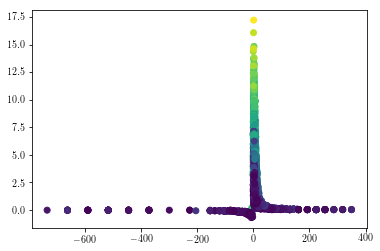

In [789]:
z_mask = (feature_array[:,2] == 3.10) & mask

plt.scatter(feature_array[z_mask,0] / feature_array[z_mask,1], 
            feature_array[z_mask,1], c=predictor_array[z_mask])

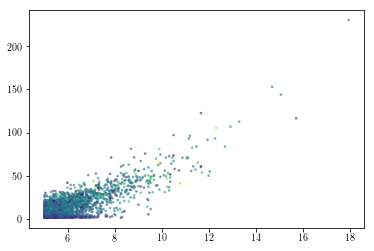

In [801]:
plt.scatter(feature_array[z_mask,1],# + (feature_array[z_mask,0] / feature_array[z_mask,1])**0.3,
            predictor_array[z_mask], c=feature_array[z_mask,0], s=3, alpha=0.5)